# Step 1: Initializing Setup

In [1]:
!set KMP_DUPLICATE_LIB_OK=TRUE
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
%cd C:\Users\ALI\Documents\Ali_Thesis\Algo2\Pretrained_UNet

C:\Users\ALI\Documents\Ali_Thesis\Algo2\Pretrained_UNet


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import math
from PIL import Image
from itertools import combinations
from collections import Counter
import cv_algorithms
import torch
import torch.nn as nn
import os
from tqdm import tqdm
import sys
import glob
import albumentations as aug
from shapely.geometry import Point, Polygon

from CropRowModel import CropRowDetectionModel # Load Crop row detection Model
from Utils import *
from visualize import visualize
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import time
from tqdm import tqdm_notebook
import matplotlib.image as mpimg

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#!nvidia-smi --query-compute-apps=pid,process_name,used_memory --format=csv
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

C:\Users\ALI\.conda\envs\LW_Unet_PT\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Step 2: Initializing Model

In [3]:
mymodel = CropRowDetectionModel(3,1) # 3 input channels (RGB) and 1 output channel
#device = torch.device("cuda")
device = torch.device("cuda")
print (device)

mymodel.load_state_dict(torch.load(r'C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\weights\\LED_Matrix_Weights.pt'))


C:\Users\ALI\.conda\envs\LW_Unet_PT\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\ALI\.conda\envs\LW_Unet_PT\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


cuda


<All keys matched successfully>

# Step 3: Prediction

In [6]:
#1.--------------------------"crop" parameter is added to the predict function--------------------------
start_time = time.time()
final_lines, line_not_detected = [], []

images = glob.glob(r'C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\00-Test_Data\\Images\\*.png')
path_lines = r"C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\00-Test_Data\\Detected\\"

#n = len(images)

isExist = os.path.exists(path_lines)
if not isExist: 
    os.makedirs(path_lines)
i=1
for input_img in tqdm(images):
    op_image_name = input_img.split('\\')[-1]
    line = predict(mymodel,input_img,op_image_name,path_lines,  device) #line = [x1,y1,x2,y2]
    
end_time = time.time()
print('Time taken: ', end_time - start_time,'s')


100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.89it/s]

Time taken:  0.8010070323944092 s


# Step 4: Quantitative Analysis

In [8]:
import os
import cv2
import numpy as np
import pandas as pd

def compute_metrics(pred_mask, true_mask):
    pred_mask = (pred_mask > 0).astype(np.uint8)
    true_mask = (true_mask > 0).astype(np.uint8)

    intersection = np.logical_and(pred_mask, true_mask).sum()
    union = np.logical_or(pred_mask, true_mask).sum()
    total_pixels = pred_mask.size
    correct = (pred_mask == true_mask).sum()

    accuracy = correct / total_pixels
    dice = (2. * intersection) / (pred_mask.sum() + true_mask.sum() + 1e-8)
    iou = intersection / (union + 1e-8)

    return accuracy, dice, iou

def evaluate_segmentation_folder(pred_folder, gt_folder, output_excel="segmentation_accuracy.xlsx"):
    results = []

    pred_files = sorted(os.listdir(pred_folder))
    
    for filename in pred_files:
        pred_path = os.path.join(pred_folder, filename)
        gt_path = os.path.join(gt_folder, filename)

        if not os.path.exists(gt_path):
            print(f"⚠️ Ground truth not found for {filename}. Skipping.")
            continue

        pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)

        if pred is None or gt is None:
            print(f"❌ Could not read {filename}. Skipping.")
            continue

        acc, dice, iou = compute_metrics(pred, gt)

        print(f"{filename} → Accuracy: {acc:.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}")
        results.append({
            "Image": filename,
            "Accuracy": acc,
            "Dice Score": dice,
            "IoU": iou
        })

    df = pd.DataFrame(results)
    
    if not df.empty:
        avg_acc = df["Accuracy"].mean()
        avg_dice = df["Dice Score"].mean()
        avg_iou = df["IoU"].mean()

        print(f"\n🔍 AVERAGE → Accuracy: {avg_acc:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")

        # Append average row
        df.loc[len(df.index)] = ["Average", avg_acc, avg_dice, avg_iou]

    df.to_excel(output_excel, index=False)
    print(f"\n✅ Evaluation complete. Results saved to: {output_excel}")


In [9]:
pred_folder = r"C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\00-Test_Data\\Detected\\"
gt_folder = r"C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\00-Test_Data\\GroundTruth"
output_excel = r"C:\\Users\\ALI\\Documents\\Ali_Thesis\\Algo2\\Pretrained_UNet\\00-Test_Data\\Quantitative_Analysis.xlsx"

evaluate_segmentation_folder(
    pred_folder=pred_folder,
    gt_folder=gt_folder,
    output_excel=output_excel
)


LED_Matrix_2025_02_24_23_24_01_3.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_24_23_24_01_4.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_24_23_24_01_Average.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_24_23_52_15_1.png → Accuracy: 0.9969, Dice: 0.9820, IoU: 0.9646
LED_Matrix_2025_02_25_00_38_42_2.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_00_38_42_Average.png → Accuracy: 0.9970, Dice: 0.9822, IoU: 0.9650
LED_Matrix_2025_02_25_01_58_53_3.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_03_10_09_3.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_03_30_21_Average.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_04_10_15_3.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_05_00_54_1.png → Accuracy: 0.9970, Dice: 0.9821, IoU: 0.9649
LED_Matrix_2025_02_25_05_22_17_5.png → Accuracy: 0.9970, Dice: 0.9821

# Step 5: Quantitative Analysis

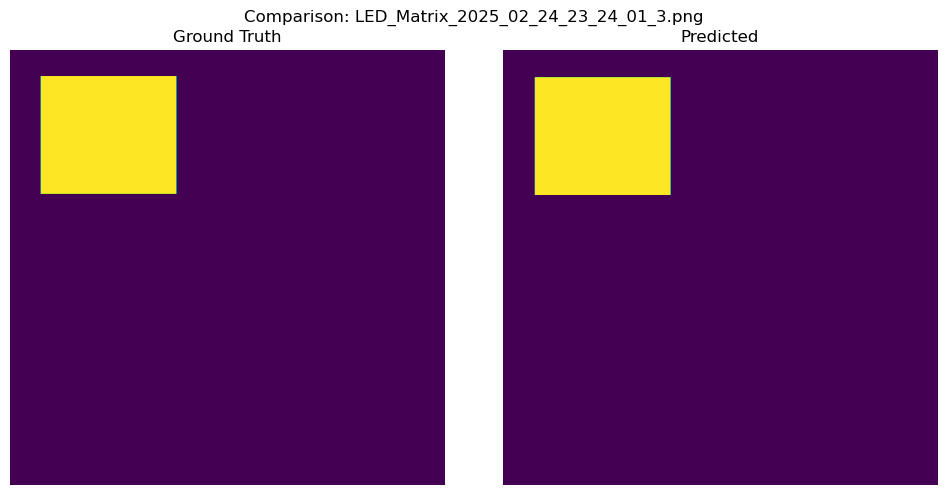

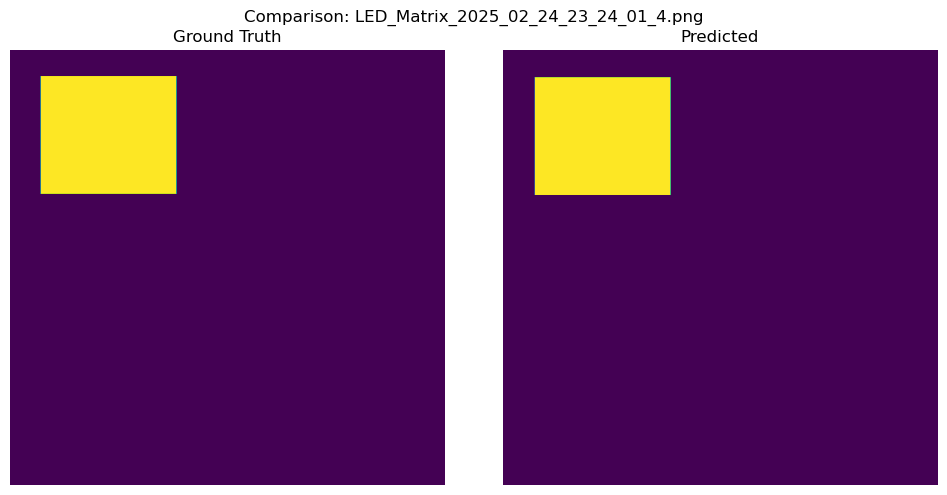

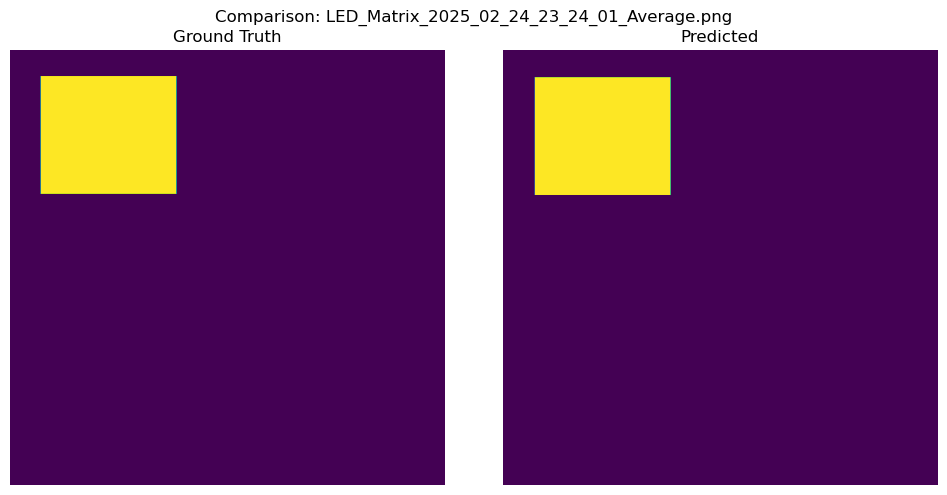

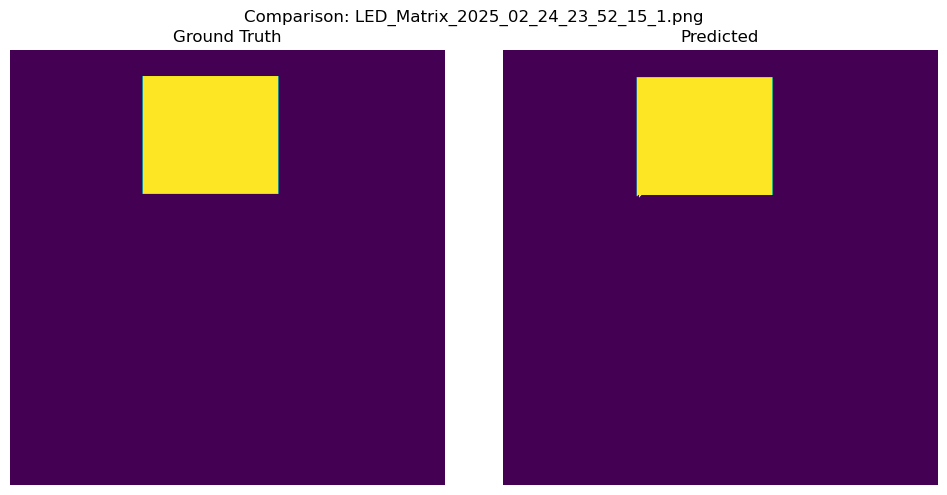

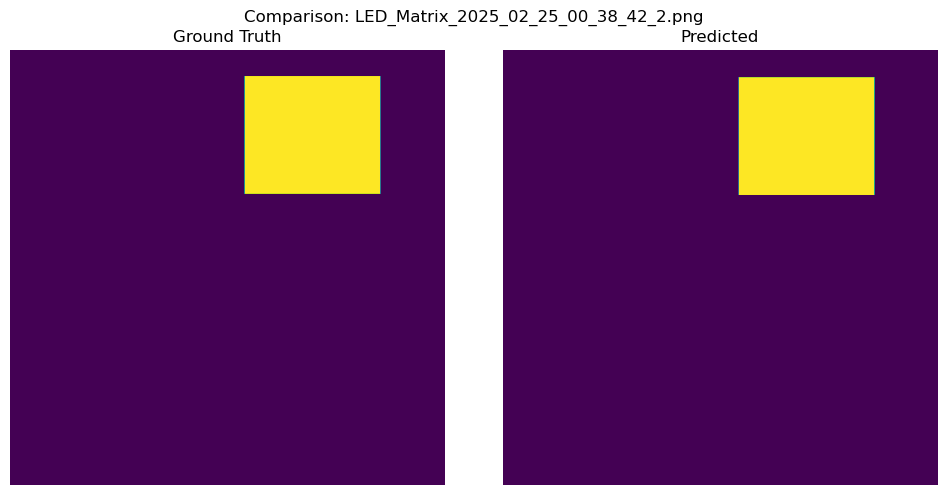

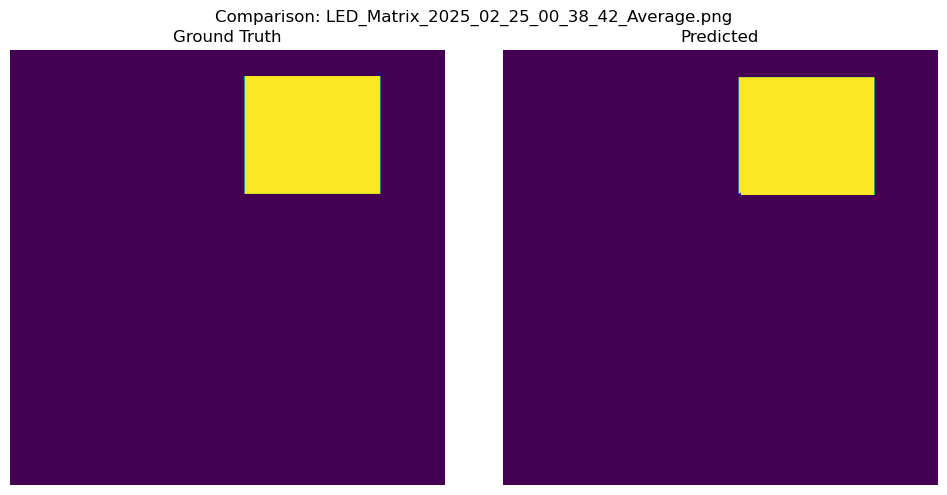

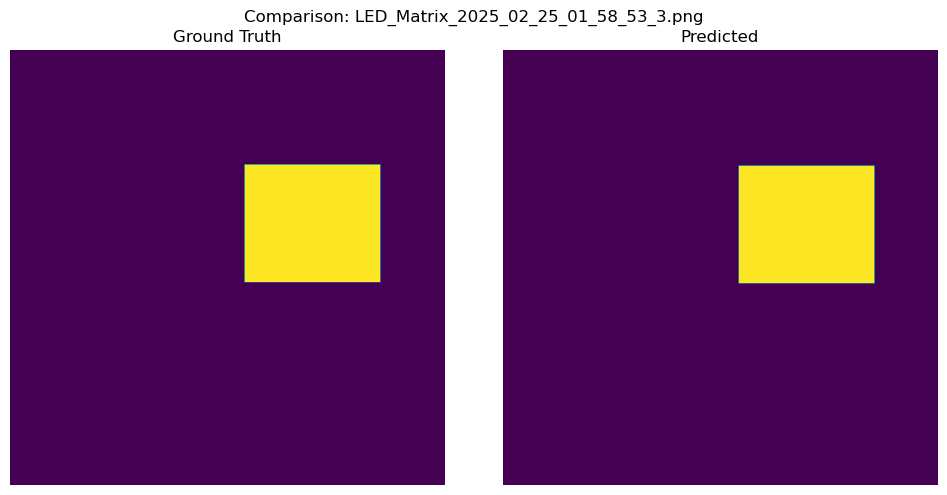

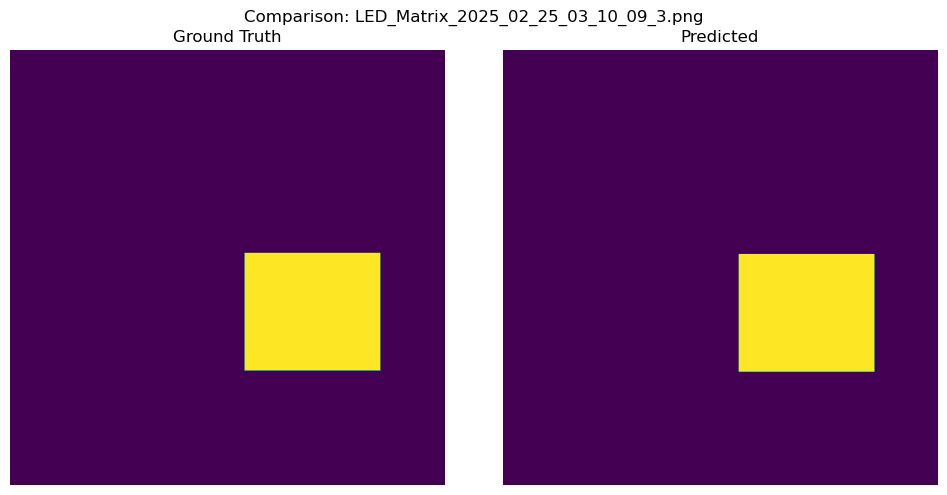

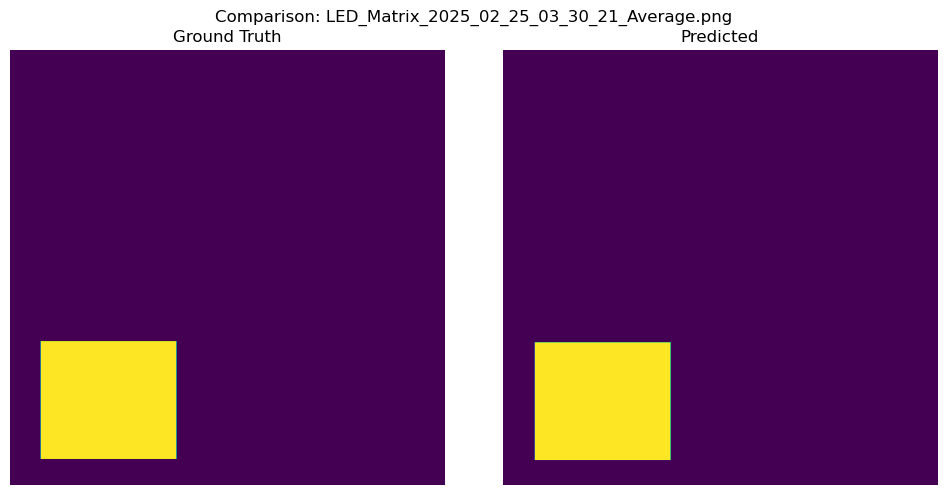

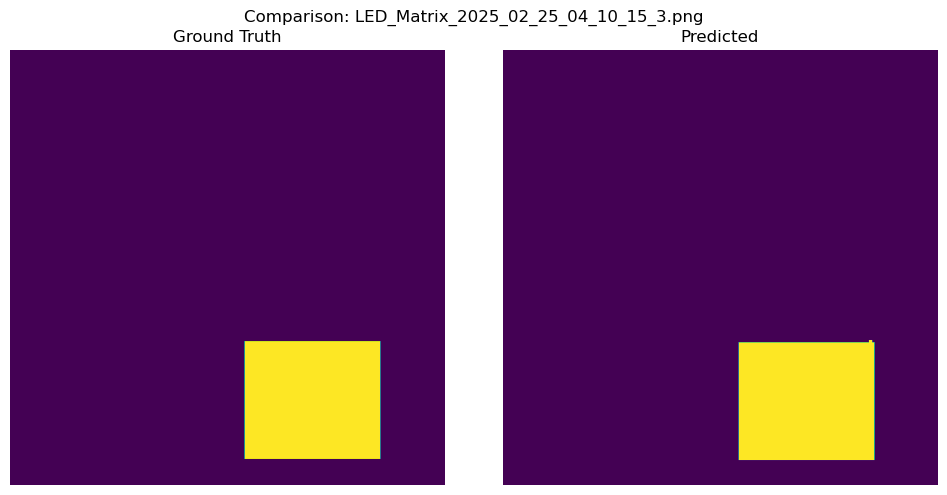

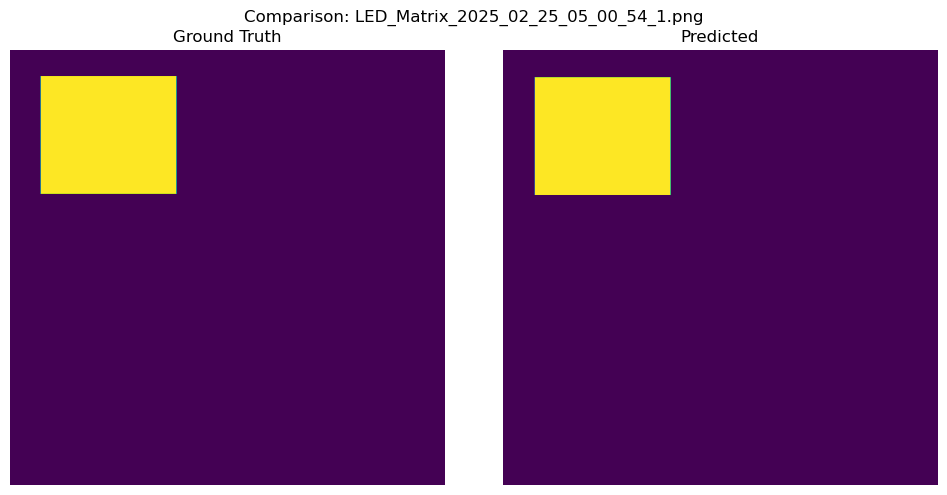

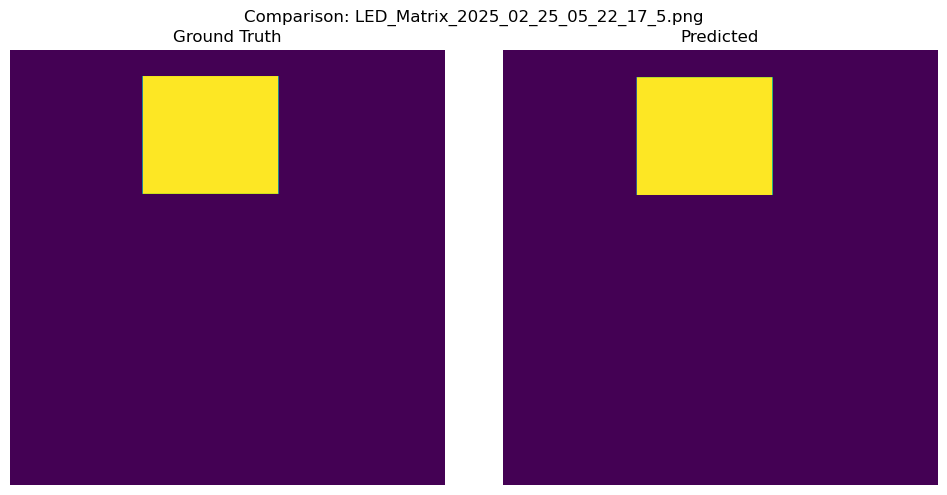

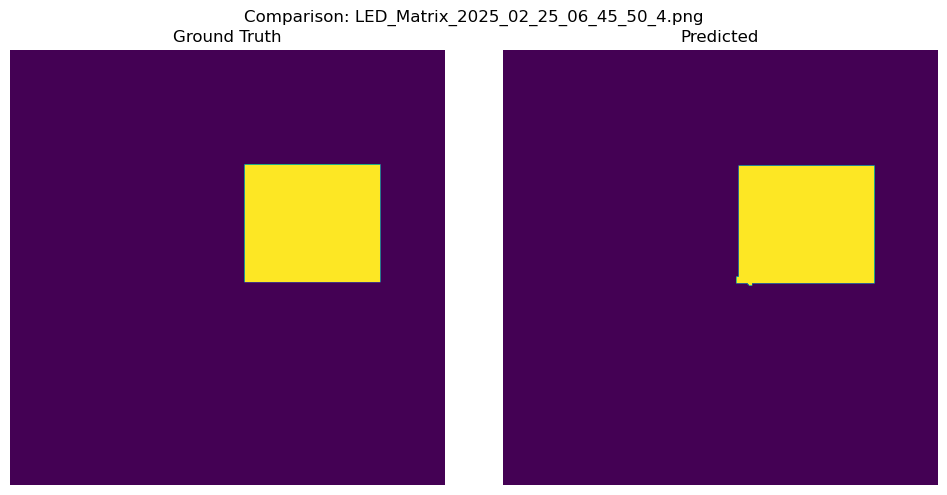

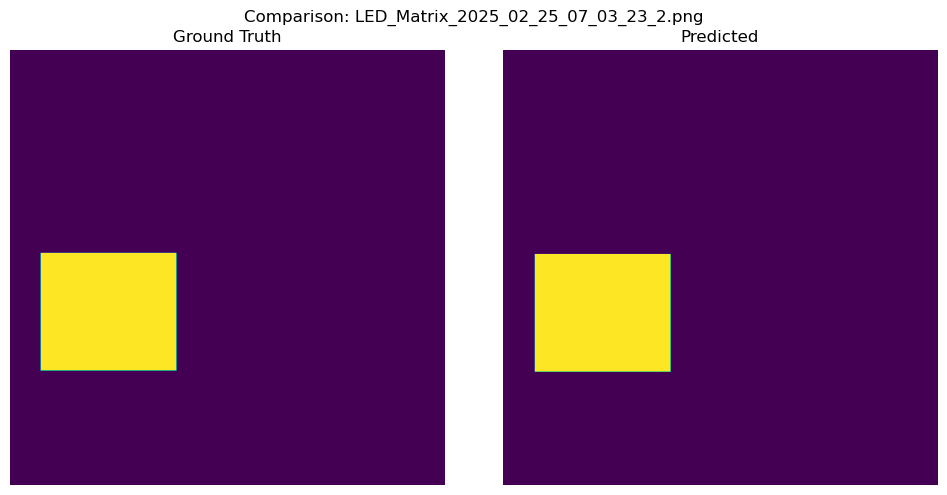

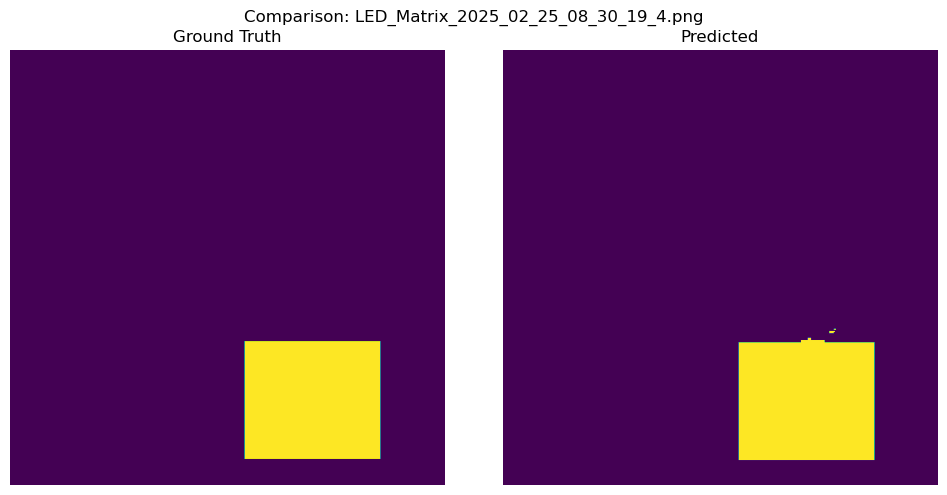

In [11]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Set your folders here
ground_truth_folder = gt_folder 
predicted_folder = pred_folder

# Get all image filenames in ground truth folder (you can filter by extension)
image_filenames = [f for f in os.listdir(predicted_folder) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg')) and not f.startswith('~$')]

# Display images
for filename in image_filenames:
    gt_path = os.path.join(ground_truth_folder, filename)
    pred_path = os.path.join(predicted_folder, filename)

    if os.path.exists(pred_path):  # Check if corresponding predicted image exists
        gt_image = Image.open(gt_path)
        pred_image = Image.open(pred_path)

        # Show side-by-side
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(gt_image)
        axes[0].set_title('Ground Truth')
        axes[0].axis('off')

        axes[1].imshow(pred_image)
        axes[1].set_title('Predicted')
        axes[1].axis('off')

        plt.suptitle(f'Comparison: {filename}')
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ Predicted image not found for: {filename}")
